In [45]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [46]:
# model expects all image data to be of the same size
# i.e. we will have to resize all images in dataset to a particular size
IMG_SIZE = (80,80)
channels = 1 # i.e. grayscale
character_path = r'./simpsons_data/simpsons_dataset/' # path to dataset

In [47]:
# we want to get top 10 characters with most images for that class

# go through every folder, get name of folder and number of images
# in the folder, and store this info in a dictionary (hashmap)
character_dict = {}
for character in os.listdir(character_path):
    character_dict[character] = len(os.listdir(os.path.join(character_path, character)))

# sort in decending order
character_dict = caer.sort_dict(character_dict, descending=True)

character_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [48]:
# Get the names of the top 10 people with most images
characters = []
count = 0
for i in character_dict:
    characters.append(i[0])
    count +=1
    if count >= 10:
        break

characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [49]:
# Create the training data
# - go through every folder inside character_path, and look at every element
#   inside the characters list
# - it will the images from the top 10 people, to the training set
# - a training set is a list. Each element in the list was another list
#   of image array and its label
train = caer.preprocess_from_dir(character_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.003500223159790039s
[INFO] At 1000 files
[INFO] 1454 files found in 0.0015757083892822266s
[INFO] At 1000 files
[INFO] 1452 files found in 0.0015926361083984375s
[INFO] At 1000 files
[INFO] 1354 files found in 0.0015377998352050781s
[INFO] At 1000 files
[INFO] 1342 files found in 0.001474142074584961s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0014121532440185547s
[INFO] At 1000 files
[INFO] 1206 files found in 0.0013608932495117188s
[INFO] At 1000 files
[INFO] 1194 files found in 0.001313924789428711s
[INFO] At 1000 files
[INFO] 1193 files found in 0.0013184547424316406s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0012128353118896484s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 8s


In [50]:
len(train) # number of images in the training set

13811

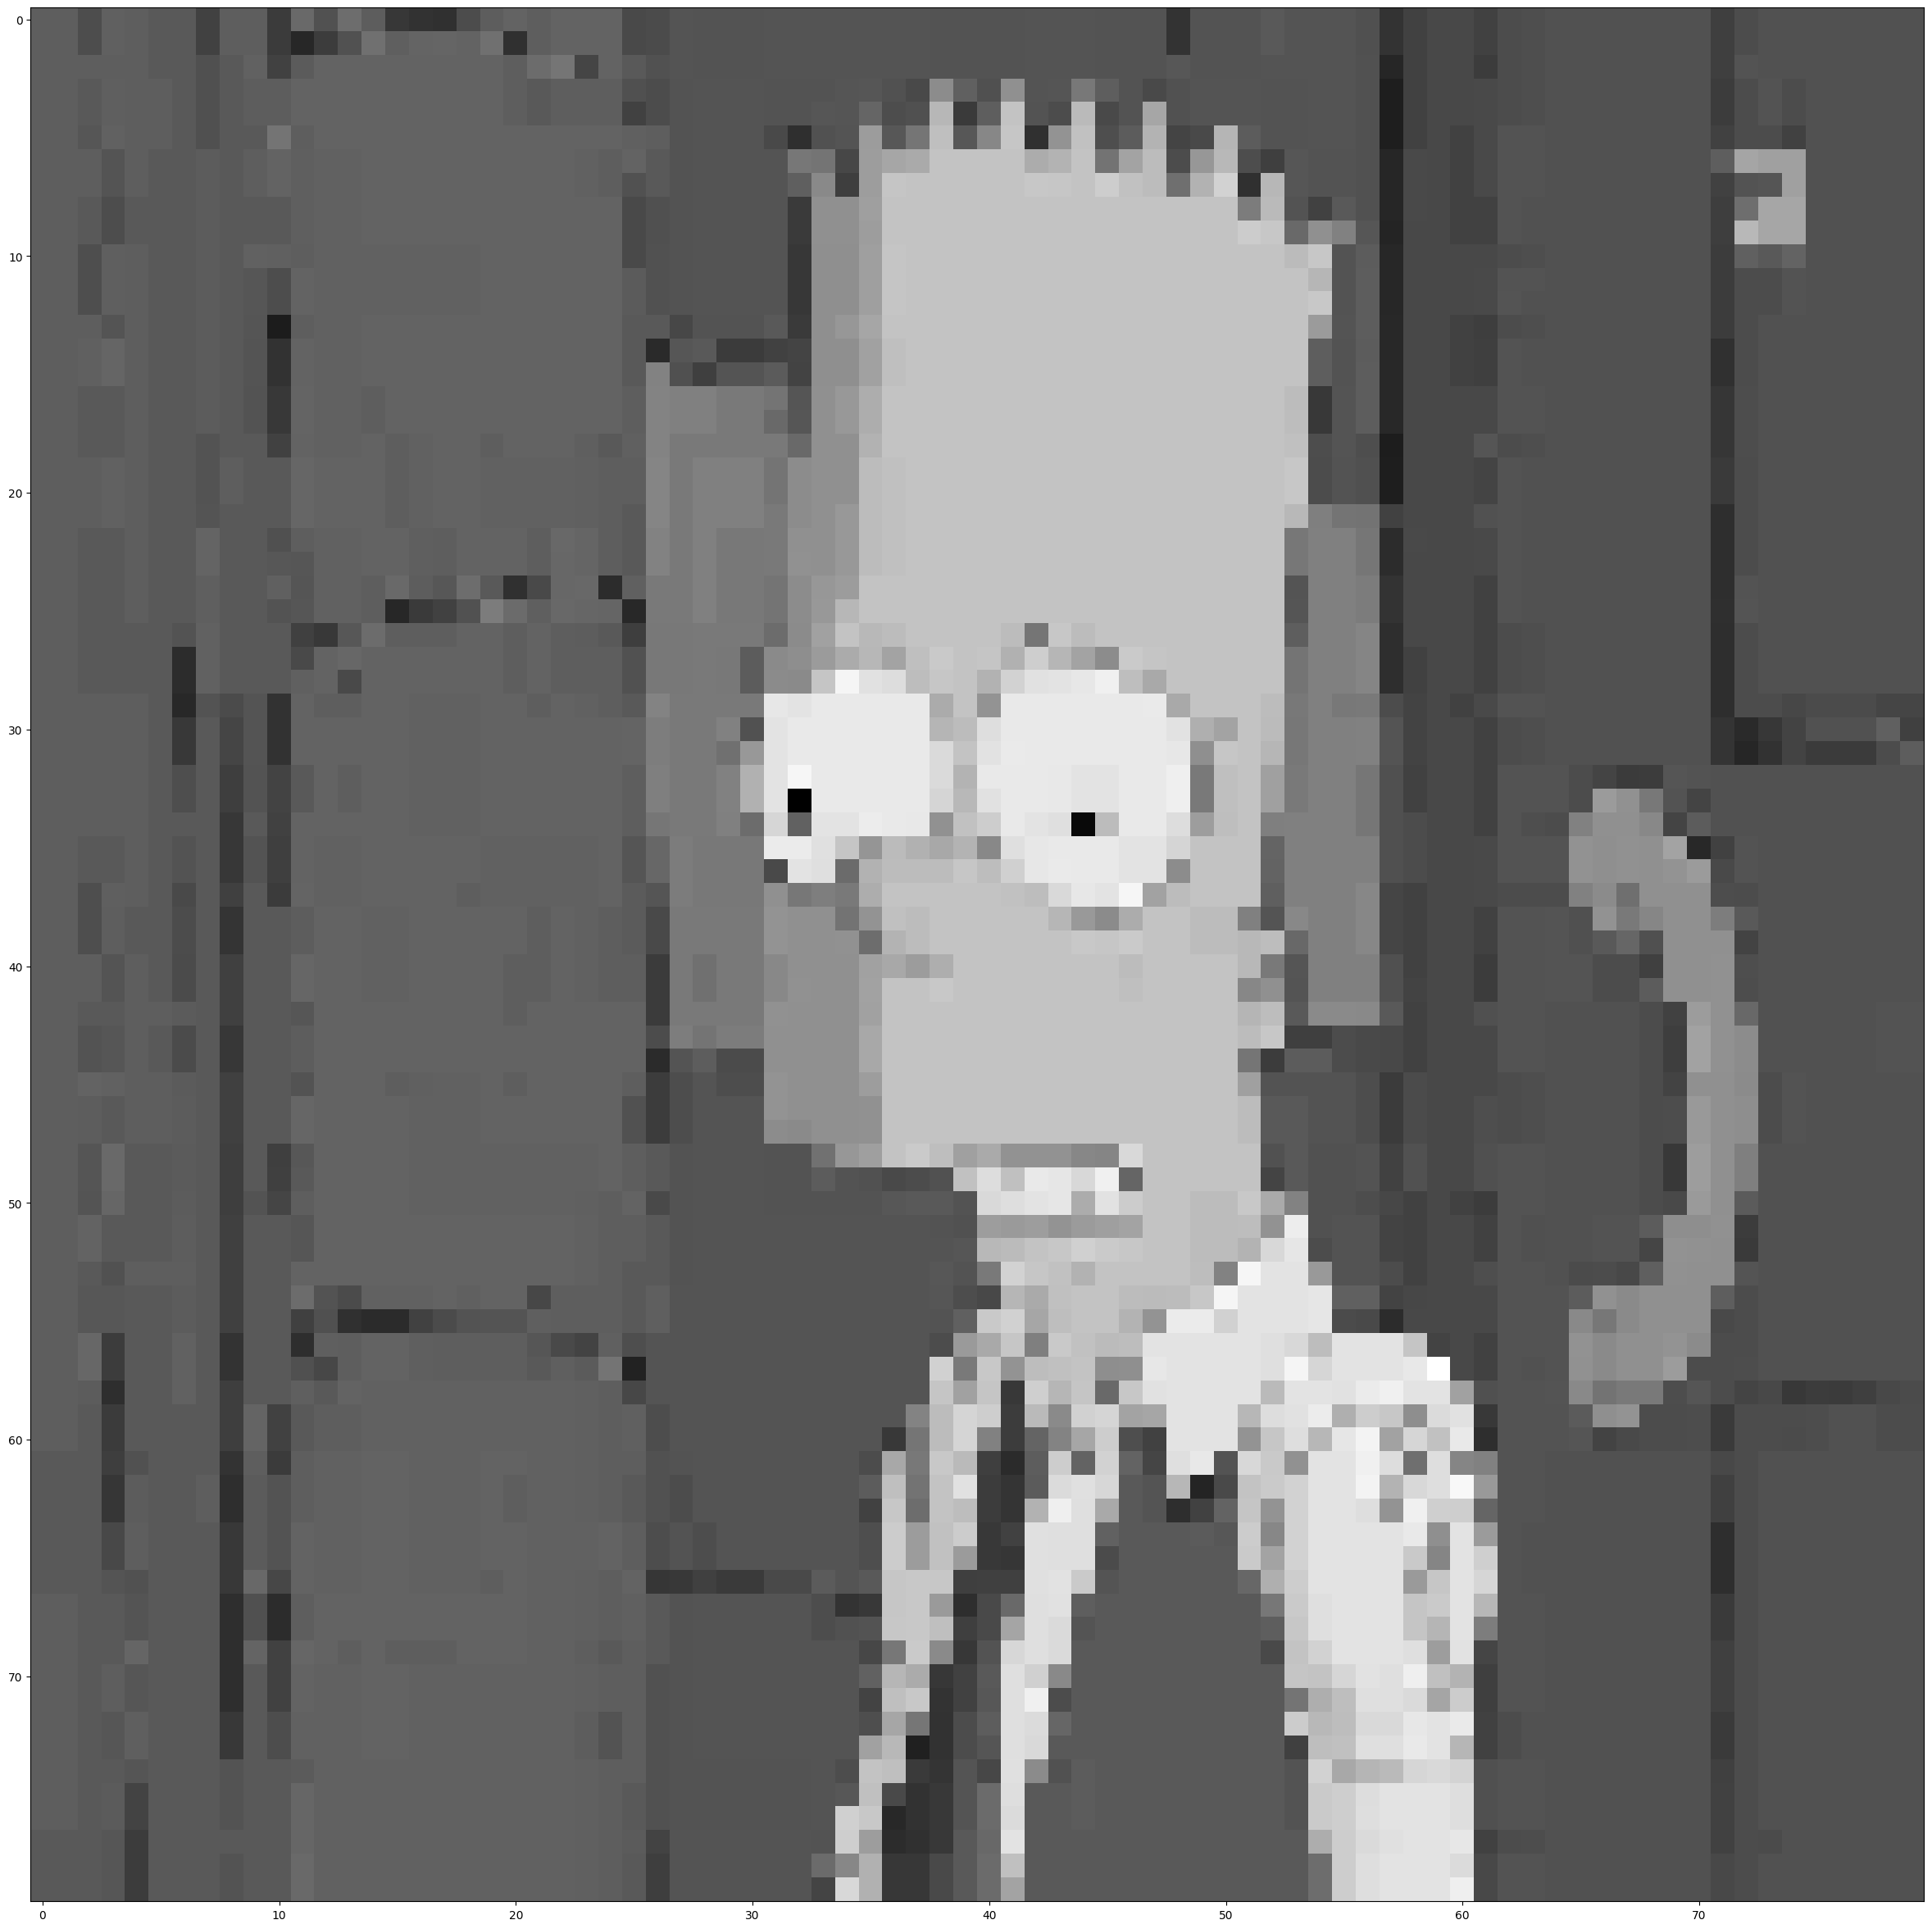

In [51]:
# diplay an image in the training set
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [52]:
# separate training set into labels and features into separate lists
# and also reshape the featureSet into a 4D tensor, so that it can be 
# fed into the model without any restrictions
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [53]:
# from tensorflow.python.keras.utils.np_utils import to_categorical # NOTE: Needed utils.np_utils
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> make data within range of (0,1)
featureSet = caer.normalize(featureSet)

# convert labels from class vector (integers) to binary class matrix.
labels = to_categorical(labels, len(characters))

In [54]:
# splitting featureset and labels into training set and validation set
# so in this case, 20% goes to validation, 80% goes to training
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)


# Extra stuff:
# import sklearn.model_selection as skm
# split_data = skm.train_test_split(featureSet, labels, test_size=.2)
# x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [55]:
# can now delete unneeded variables
del train 
del featureSet
del labels
gc.collect()

4052

In [56]:
BATCH_SIZE = 32
EPOCHS = 10

In [57]:
# Image data generator
# - image generator that makes new images from existing ones to improve our network
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)


In [58]:
# Creating the model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, 
                                          output_dim=len(characters), loss='binary_crossentropy', decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True)

/home/ashish/miniconda3/envs/cv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ashish/miniconda3/envs/cv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


ValueError: Argument(s) not recognized: {'lr': 0.001}

In [18]:
model.summary()

NameError: name 'model' is not defined